In [1]:
from core.preprocessing import make_small_train, make_small_dev, StatisticalClearSky, DataManager, make_batch, CenterScale
import numpy as np
import pandas as pd
df = pd.read_pickle('data/master_dataset.pkl').fillna(0)
df = df.loc['2015-07-15':'2017-07-14']
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', context='talk')

In [5]:
def plot_trends_and_total(df, start=None, stop=None):
    if start is None:
        start = df.index[0]
    if stop is None:
        stop = df.index[-1]
    cols = df.columns
    fig, axes = plt.subplots(nrows=2, figsize=(12,10), sharex=True)
    df.loc[start:stop].plot(y=cols[:-1], legend=False, linewidth=1, ax=axes[0])
    df.loc[start:stop].plot(y=cols[-1], linewidth=1, ax=axes[1])

mixed = make_small_train(df, 'mixed')
plot_trends_and_total(mixed)

sunny = make_small_train(df, 'sunny')
plot_trends_and_total(sunny)

cloudy = make_small_train(df, 'cloudy')
plot_trends_and_total(cloudy)

comb = make_small_train(df, 'combined')
plot_trends_and_total(comb)

dev = make_small_dev(df)
plot_trends_and_total(dev)

from core.problems import ManyToOneRegression

# Problem parameters
window = 5*12 # window size (to be determined from correlation analysis)
future = 3*12  # prediction window into the future

# Optimization parameters
nepochs = 50
batchsize = 1000

problem = ManyToOneRegression(mixed, window=window, future=future)

feat = problem.featurize(100)

%time np.array([mixed.iloc[i:i+window, :-1].values.ravel() for i in xrange(len(mixed) - problem.window - problem.future)]).shape

mixed.shape

i = 75
mixed.iloc[i:i+window, :-1].values.ravel()

In [10]:
dm = DataManager()
dm.load_all_and_split(reindex=True)

In [16]:
scale = CenterScale(y_data=-1)
scale.fit(dm.original_train)

In [17]:
test = scale.apply(dm.original_train)

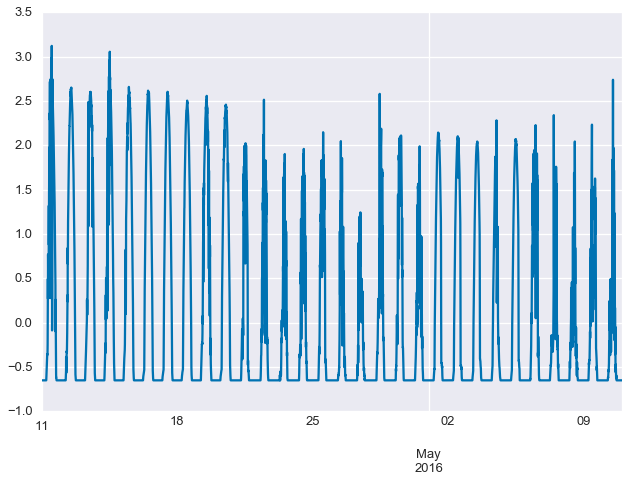

In [18]:
test['S03'].plot()

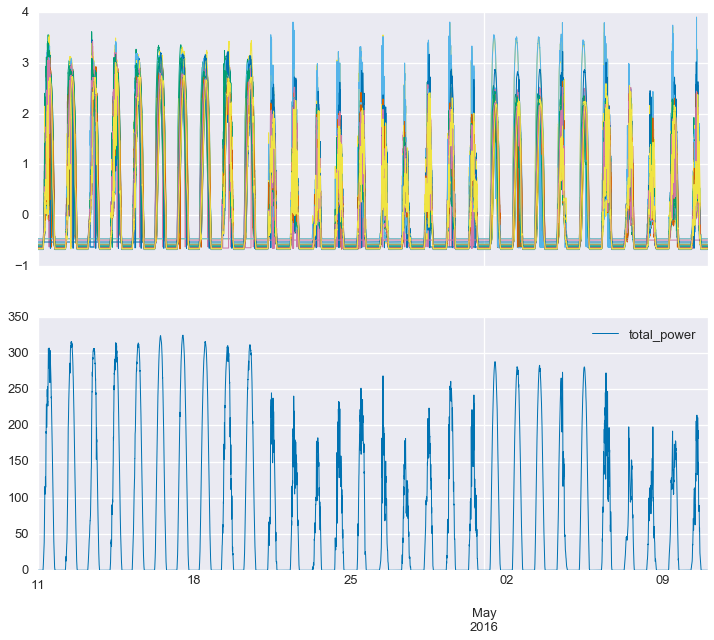

In [19]:
plot_trends_and_total(test)

In [ ]:
dm.swap_index()

In [ ]:
present = 3*12
future = 3*12

dm = DataManager()
dm.load_all_and_split(kind='all')
dftrain = dm.original_train
dfdev = dm.original_dev

In [ ]:
X, Y = make_batch(dftrain, 100, present, future, exo=True)

In [ ]:
X.shape

In [ ]:
X[4,-5:]

In [ ]:
for s in xrange(20):
    plt.plot(X[52,s*present:(s+1)*present])

In [ ]:
[plt.plot(Y[52])]

In [ ]:
dftrain.index.time[0]

In [23]:
dm = DataManager()
dm.load_all_and_split(kind='all')
dftrain = dm.detrended_train
dfdev = dm.detrended_dev

scale = CenterScale(y_data=-1)
scale.fit(dftrain)
dftrain = scale.apply(dftrain)
dfdev = scale.apply(dfdev)

In [25]:
present = 3*12
future = 3*12

In [27]:
X, Y = make_batch(dftrain, 100, present, future, exo=True)

In [28]:
X.shape

(100, 2342)

In [29]:
from scipy.signal import fftconvolve

In [31]:
s = fftconvolve(dm.original_train['total_power'], np.ones(12), mode='same')
q = fftconvolve(np.power(dm.original_train['total_power'], 2), np.ones(12), mode='same')

In [32]:
var = (q - np.power(s, 2) *1./ 12) / (12 - 1)
stdev = np.sqrt(var)

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


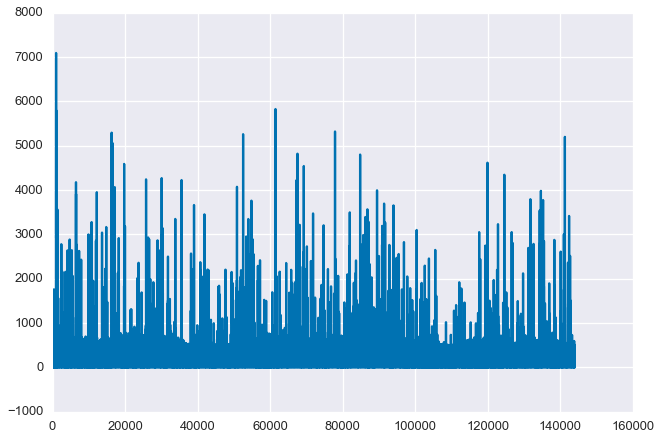

In [33]:
plt.plot(var)

In [34]:
from scipy.ndimage.filters import uniform_filter

def window_stdev(arr, radius):
    c1 = uniform_filter(arr, radius*2, mode='constant', origin=-radius)
    c2 = uniform_filter(arr*arr, radius*2, mode='constant', origin=-radius)
    return ((c2 - c1*c1)**.5)[:-radius*2+1,:-radius*2+1]

In [35]:
stdev2 = window_stdev(dm.original_train['total_power'], 6)

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


IndexError: too many indices for array

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=True).std()
  """Entry point for launching an IPython kernel.


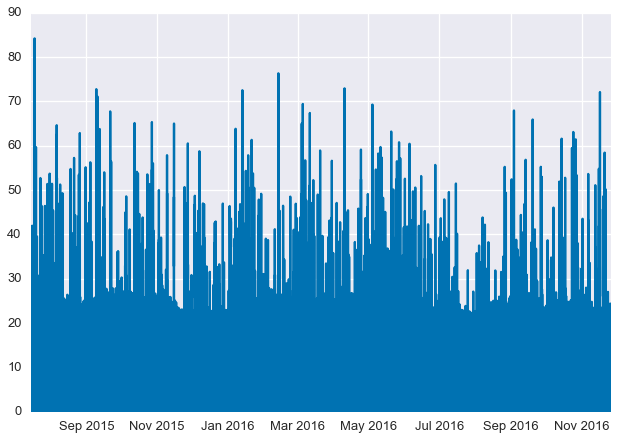

In [38]:
plt.plot(pd.rolling_std(dm.original_train['total_power'], window=12, center=True))